(c) 2025 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [97]:
# Import base libraries
import os
import glob
import gc
import pickle

# Import JAX-related libraries
import jax
from jax import random
import jax.numpy as jnp
from numpyro.optim import Adam
import numpyro

# Import numpy for array manipulation
import numpy as np
# Import statsmodels for statistical modeling
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import NegativeBinomial
# Import scipy for special functions
import scipy as sp
# Import library to load h5ad files
import anndata as ad
# Import pandas for data manipulation
import pandas as pd
# Import scribe
import scribe
# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
# Set plotting style
scribe.viz.matplotlib_style()

# Import colors
color_palette = scribe.viz.colors()

# Exploratory data analysis of `Sanity` datasets

In this notebook, we will perform an exploratory data analysis of the datasets
used in the `Sanity` paper. This will give us a sense of the type of output that
different normalization methods produce.

## Raw counts exploratory data analysis

Let's begin by listing the raw count files.

In [2]:
# Define data directory
DATA_DIR = f"{scribe.utils.git_root()}/data/sanity"

# List all files in the data directory
files = glob.glob(f"{DATA_DIR}/*counts.txt.gz", recursive=True)

files

['/app/data/sanity/Gruen_RNA_serum_UMI_counts.txt.gz',
 '/app/data/sanity/LaManno_ES_UMI_counts.txt.gz',
 '/app/data/sanity/Simulated_Branched_Random_Walk_UMI_counts.txt.gz',
 '/app/data/sanity/LaManno_MouseEmbryo_UMI_counts.txt.gz',
 '/app/data/sanity/Gruen_SC_2i_UMI_counts.txt.gz',
 '/app/data/sanity/Zeisel_UMI_counts.txt.gz',
 '/app/data/sanity/Gruen_RNA_2i_UMI_counts.txt.gz',
 '/app/data/sanity/Chen_UMI_counts.txt.gz',
 '/app/data/sanity/LaManno_Embryo_UMI_counts.txt.gz',
 '/app/data/sanity/Simulated_Baron_Independent_Genes_UMI_counts.txt.gz',
 '/app/data/sanity/Gruen_SC_serum_UMI_counts.txt.gz',
 '/app/data/sanity/Baron_UMI_counts.txt.gz']

Let's take a look at the first few rows of the one of the files.

In [3]:
# Read the gzipped file
baron_counts = pd.read_csv(
    f"{DATA_DIR}/Baron_UMI_counts.txt.gz",
    compression='gzip',
    sep='\t'  # tab-separated values
)

# Take a look at the first few rows
baron_counts.head()

,GeneID,human1_lib1_final_cell_0001,human1_lib1_final_cell_0002,human1_lib1_final_cell_0003,human1_lib1_final_cell_0004,human1_lib1_final_cell_0005,human1_lib1_final_cell_0006,human1_lib1_final_cell_0007,human1_lib1_final_cell_0008,human1_lib1_final_cell_0009,...,human1_lib3_final_cell_0731,human1_lib3_final_cell_0732,human1_lib3_final_cell_0733,human1_lib3_final_cell_0734,human1_lib3_final_cell_0735,human1_lib3_final_cell_0736,human1_lib3_final_cell_0737,human1_lib3_final_cell_0738,human1_lib3_final_cell_0739,human1_lib3_final_cell_0740
0,A1BG,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A1CF,4,0,0,0,0,1,0,1,0,...,0,0,0,1,0,0,1,0,0,0
2,A2M,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,A4GALT,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AAAS,0,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


Let's plot the distribution of total counts per cell.

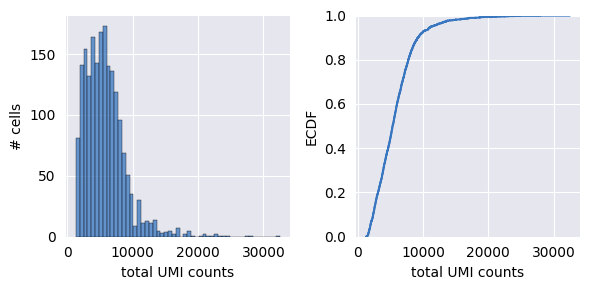

In [4]:
# Initialize figure
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# Compute total counts per cell removing the first column (gene names)
total_counts = baron_counts.iloc[:, 1:].sum(axis=0)

# Plot the distribution of total counts per cell
sns.histplot(total_counts, ax=axes[0], color=colors['blue'])
sns.ecdfplot(total_counts, ax=axes[1], color=colors['blue'])

# Set title and labels
axes[0].set_xlabel('total UMI counts')
axes[0].set_ylabel('# cells')
axes[1].set_xlabel('total UMI counts')
axes[1].set_ylabel('ECDF')

plt.tight_layout()

Let's check if the total counts can be fit to a negative binomial distribution.

In [50]:
# Fit Negative Binomial model
model = NegativeBinomial(total_counts.values, np.ones_like(total_counts.values))
result = model.fit()

Optimization terminated successfully.
         Current function value: 9.328694
         Iterations: 4
         Function evaluations: 5
         Gradient evaluations: 5


Let's compare the fitted distribution with the ECDF of the data.

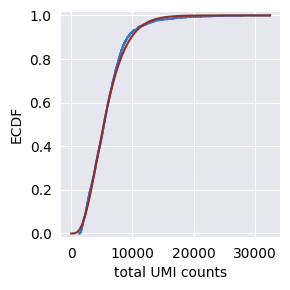

In [98]:
# Extract parameters (note: statsmodels uses different parameterization)
mu = np.exp(result.params[0])  # mean
alpha = result.params[1]  # dispersion parameter
p = 1 / (1 + mu * alpha)  # convert to p parameter
r = 1 / alpha  # convert to r parameter

# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

# Compute total counts per cell removing the first column (gene names)
total_counts = baron_counts.iloc[:, 1:].sum(axis=0)

# Plot ECDF
sns.ecdfplot(total_counts, ax=ax, color=color_palette['blue'])

# Add the fitted distribution
x = np.arange(0, np.max(total_counts), 1)

# Calculate PMF and CDF
cdf = sp.stats.nbinom.cdf(x, n=r, p=p)

# Plot PMF and CDF
ax.plot(x, cdf, color=color_palette['dark_red'], label='Negative Binomial')

# Set title and labels
ax.set_xlabel('total UMI counts')
ax.set_ylabel('ECDF')

# Set y-scale limits
ax.set_ylim(-0.015, 1.015)

plt.tight_layout()

The total UMI counts per cell for this dataset seem to be well fit by a negative
binomial distribution.


Let's now compute the total counts per cell for all the files to then plot the
ECDF.

In [63]:
# Initialize dictionary to store total counts per cell
total_counts_dict = {}

# Loop over all files
for file in files:
    # Read the gzipped file
    counts = pd.read_csv(file, compression='gzip', sep='\t')

    # Compute total counts per cell removing the first column (gene names)
    total_counts = counts.iloc[:, 1:].sum(axis=0)

    # Store the total counts in the dictionary
    total_counts_dict[file] = total_counts

Now, let's plot the ECDF of the total counts per cell for all the files.

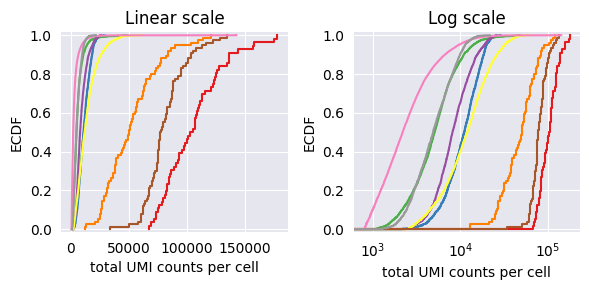

In [64]:
# Initialize figure
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# Define colors
colors = sns.color_palette("Set1")

# Loop through keys and values in the dictionary
for (file, total_counts), color in zip(total_counts_dict.items(), colors):
    sns.ecdfplot(total_counts, ax=axes[0], label=file, color=color)
    sns.ecdfplot(total_counts, ax=axes[1], label=file, color=color)

# Set title and labels
axes[0].set_title('Linear scale')
axes[1].set_title('Log scale')
axes[0].set_xlabel('total UMI counts per cell')
axes[0].set_ylabel('ECDF')
axes[1].set_xlabel('total UMI counts per cell')
axes[1].set_ylabel('ECDF')

# Set 2nd axis to log scale
axes[1].set_xscale('log')

# Set y-scale limits
axes[0].set_ylim(-0.015, 1.015)
axes[1].set_ylim(-0.015, 1.015)

plt.tight_layout()


We can see that there's a drastic difference in the total counts per cell between
the different datasets. This makes the normalization scheme extremely important
to make the datasets.

Let's now fit a negative binomial distribution to the total counts per cell for
each dataset.

In [68]:
# Initialize dictionary to store parameters
params_dict = {}

# Loop over total counts per cell
for file, total_counts in total_counts_dict.items():
    # Fit Negative Binomial model
    model = NegativeBinomial(total_counts.values, np.ones_like(total_counts.values))
    result = model.fit(disp=False)

    # Extract parameters (note: statsmodels uses different parameterization)
    mu = np.exp(result.params[0])  # mean
    alpha = result.params[1]  # dispersion parameter
    p = 1 / (1 + mu * alpha)  # convert to p parameter
    r = 1 / alpha  # convert to r parameter

    # Store the parameters in the dictionary
    params_dict[file] = {'r': r, 'p': p}

Now, let's plot the ECDF of the total counts per cell for each dataset and compare
the fitted distribution with the ECDF of the data.


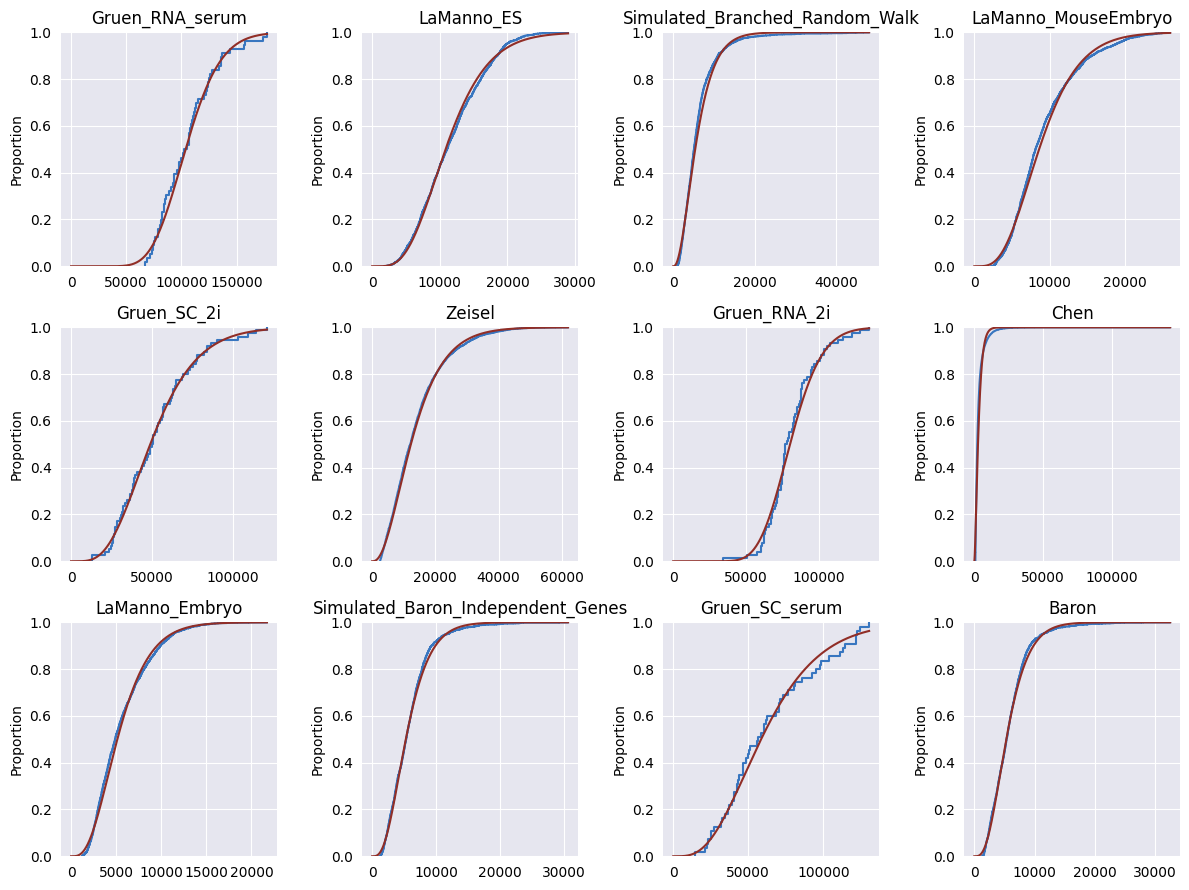

In [101]:
# Define number of rows and columns for plots
n_rows = 3
n_cols = 4

# Initialize figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))

# Flatten axes
axes = axes.flatten()

# Loop over total counts per cell
for (i, (file, total_counts)) in enumerate(total_counts_dict.items()):
    # Plot ECDF
    sns.ecdfplot(total_counts.values, ax=axes[i], color=color_palette['blue'])

    # Add the fitted distribution
    x = np.arange(0, np.max(total_counts), 1)
    # Extract parameters
    r = params_dict[file]['r']
    p = params_dict[file]['p']

    # Calculate PMF and CDF
    cdf = sp.stats.nbinom.cdf(x, n=r, p=p)

    # Plot PMF and CDF
    axes[i].plot(x, cdf, color=color_palette['dark_red'])

    # Extract file name
    file_name = file.split('/')[-1].replace('_UMI_counts.txt.gz', '')

    # Add file name as title
    axes[i].set_title(file_name)

plt.tight_layout()

In [100]:
files

['/app/data/sanity/Gruen_RNA_serum_UMI_counts.txt.gz',
 '/app/data/sanity/LaManno_ES_UMI_counts.txt.gz',
 '/app/data/sanity/Simulated_Branched_Random_Walk_UMI_counts.txt.gz',
 '/app/data/sanity/LaManno_MouseEmbryo_UMI_counts.txt.gz',
 '/app/data/sanity/Gruen_SC_2i_UMI_counts.txt.gz',
 '/app/data/sanity/Zeisel_UMI_counts.txt.gz',
 '/app/data/sanity/Gruen_RNA_2i_UMI_counts.txt.gz',
 '/app/data/sanity/Chen_UMI_counts.txt.gz',
 '/app/data/sanity/LaManno_Embryo_UMI_counts.txt.gz',
 '/app/data/sanity/Simulated_Baron_Independent_Genes_UMI_counts.txt.gz',
 '/app/data/sanity/Gruen_SC_serum_UMI_counts.txt.gz',
 '/app/data/sanity/Baron_UMI_counts.txt.gz']